In [300]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 24 13:35:08 2023
​
@author: brittsc
​
This script is to calculate number size distributions from outputted number
concentration N and mass mixing ratio q, in first order for cloud droplets only.
"""
import numpy as np, matplotlib.pyplot as plt
from scipy.special import gamma
from netCDF4 import Dataset
import xarray as xr
import wrf
import tqdm
import datetime
from analysis_utils import *

import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../HoloAnalysis')
from HoloCluster import HoloCluster

plt.rc('text', usetex=True)


datapaths = ['/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d03_2019-11-11_12:00:00',
 '/nird/projects/NS9600K/brittsc/230123_Morrison_def_SIP_mod_HM_limits/wrfout_d03_2019-11-11_12:00:00',
 '/nird/projects/NS9600K/brittsc/221126_Morrison_adapted_no_SIP/wrfout_d03_2019-11-11_12:00:00',
 '/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d03_2019-11-11_12:00:00']

In [386]:

def shape_parameter(N, p, T):
    """
    N: cloud droplet number concentration
    p: pressure (in Pa)
    T: temperature
    """
    rho_air = p / (287.15 * T)
    PGAM = 0.0005714 * (N / 1e+6 * rho_air) + 0.2714
    PGAM = 1. / (PGAM**2)-1.
    PGAM = max(PGAM, 2.)
    PGAM = min(PGAM, 10.)
    return PGAM

def lambda_cloud(N, q, mu):
    rho_w = 997.
    c = rho_w * np.pi / 6
    d = 3.
    a = c * N * gamma(mu + d + 1)
    b = q * gamma(mu + 1)
    e = (a / b)**(1 / d)
    return e

def N_0(N, lam, mu):
    N_0 = N * lam**(mu + 1) / gamma(mu + 1)
    return N_0

def number_size_distribution(D, N, q, p, T, return_params=False):
    """
    Input:
        D: droplet diameter in m
        N: droplet number concentration in m-3
        q: cloud water mixing ratio in kg kg-1
        p: pressure in Pa
        T: temperature in Kelvin
    
    Output:
        N: cloud droplet size distribution in micrometer-1 m-3
    """
    mu = shape_parameter(N, p, T)
    lam = lambda_cloud(N, q, mu)
    N_zero = N_0(N, lam, mu)
    N = N_zero * np.exp(-lam * D) * (D**mu) * 1e-6
    #print("mu: ", mu, "; lam: ", lam, "; N_0: ", N_zero)
    if return_params:
        return N, mu, lam, N_zero
    else:
        return N

def get_SD(data, x=np.arange(0, 1e-4, 1e-6), return_params=False):
    N = 10.*1e+6 #in m-3
    P = (data.P + data.PB).to_numpy()
    theta = data.T.to_numpy() + 300
    T = theta * (P / 100000)**0.2854
    q = data.QCLOUD.to_numpy()
    
    #print(q, P, T)
    return number_size_distribution(x,N,q,P,T, return_params=return_params)

In [51]:
q, P, T

(array(0.00013189, dtype=float32),
 array(89417.305, dtype=float32),
 262.90019948549593)

mu:  10.0 ; lam:  481141.3992650942 ; N_0:  8.81529728375042e+62


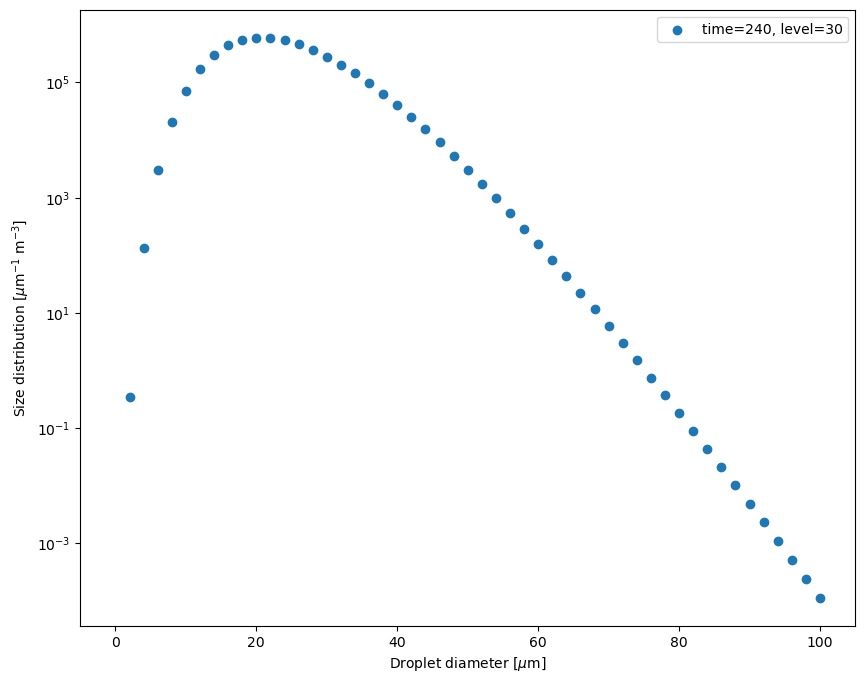

In [63]:
N = 10.*1e+6 #in m-3
lat = 60
lon = 55
timestep = 240
level = 30

datapath = "/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d03_2019-11-11_12:00:00"

#wrfOutputFile = Dataset("/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d03_2019-11-11_12:00:00")

data = xr.open_dataset(datapath).isel(Time=timestep, south_north=lat, west_east=lon, bottom_top=level)

#P = wrfOutputFile.variables["P"][timestep,level,lat,lon]+wrfOutputFile.variables["PB"][timestep,level,lat,lon]
P = (data.P + data.PB).to_numpy()

pot_T = data.T.to_numpy() + 300
T = pot_T * (P / 100000)**0.2854
#q = wrfOutputFile.variables["QCLOUD"][timestep,level,lat,lon]
q = data.QCLOUD.to_numpy()

diameters = np.arange(0,1e-4,2e-6) #up to 0.1mm in 2 micrometer steps
#    print(P,T,diameters,N,q)
size_distr = number_size_distribution(diameters,N,q,P,T)

plt.figure(figsize=(10,8))
plt.scatter(diameters*1e+6,size_distr,label='time='+str(timestep)+', level='+str(level))
plt.yscale('log')
plt.xlabel('Droplet diameter [$\mu$m]')
plt.ylabel('Size distribution [$\mu$m$^{-1}$ m$^{-3}$]')
plt.legend()
#plt.xlim(1.1, 40)
#plt.ylim(0.1, 10000000)
#fig_name = 'cloud_droplet_size_distr_time'+str(timestep)+'_level'+str(level)+'_20191112'+'.png'
plt.show()

In [64]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    if len(datenum.shape) == 0:
        days = datenum % 1
        return dt.datetime.fromordinal(int(datenum)) \
            + dt.timedelta(days=days) \
            - dt.timedelta(days=366)
    else:
        dates = []
        for dn in datenum:
            days = dn % 1
            dates.append(dt.datetime.fromordinal(int(dn)) \
                         + dt.timedelta(days=days) \
                         - dt.timedelta(days=366))
        return np.array(dates)

def holoInCloudMsk(inp, data):
    msk = xr.where(data.instData_incloud == 1, x=1, y=np.nan)
    return inp * msk

def find_base(data, datapath, cld_thrsh=0.9, t=None, xslice=(None, None), yslice=(None, None)):
    h = wrf.getvar(Dataset(datapath), 'z').isel(west_east=xslice, south_north=yslice).to_numpy()

    if t is not None:
        hc = xr.where(data.CLDFRA.isel(Time=t, bottom_top=slice(0,84)) > cld_thrsh, x=1, y=0) * h[:84, :, :]
    else:
        hc = xr.where(data.CLDFRA.isel(bottom_top=slice(0,84)) > cld_thrsh, x=1, y=np.nan) * h[:84, :, :]

    cloudbase = hc.argmin(dim='bottom_top')
    return cloudbase.rename('Cloud-base level')

def select_base(indata, cloudbase, n_levels=10):
    return indata.where((indata.bottom_top < cloudbase + n_levels) 
                        & (indata.bottom_top >= cloudbase) 
                        & (indata.bottom_top != 0), other=np.nan)

def _convert(datapath=None, loc=(78.92759354100885, 11.94456029591745)):
    '''Prepares model dataset for a 2x2 box around specified location only.
    Upto model level 85, time from 10:00 to 18:00'''
    HB_x, HB_y = wrf.ll_to_xy(wrfin=Dataset(datapath), 
                          latitude=loc[0], longitude=loc[1], meta=False)
    
    xslice = slice(HB_x, HB_x + 2)
    yslice = slice(HB_y, HB_y + 2)

    data = xr.open_dataset(datapath, engine='netcdf4').isel(
        bottom_top=slice(0, 85),
        Time=slice(264, -71), 
        bottom_top_stag=slice(0, 85), 
        west_east=xslice, 
        south_north=yslice,
        west_east_stag=xslice, 
        south_north_stag=yslice)#.mean(dim=['west_east', 'south_north'])


    return data

In [19]:
loc=(78.92759354100885, 11.94456029591745)

HB_x, HB_y = wrf.ll_to_xy(wrfin=Dataset(datapaths[0]), 
                          latitude=loc[0], longitude=loc[1], meta=False)
HB_x, HB_y

In [283]:
MD = _convert(datapaths[0])
MA = _convert(datapaths[2])

In [408]:
datas = [_convert(datapaths[i]) for i in range(4)]
datas_F1 = [datas[i].isel(Time=slice(5, 12)) for i in range(4)]
datas_F2 = [datas[i].isel(Time=slice(32, 48)) for i in range(4)]

In [409]:
bases_F1 = [find_base(datas_F1[i], datapaths[i], 
        xslice=slice(HB_x, HB_x + 2), yslice=slice(HB_y, HB_y + 2)) for i in range(4)]
bases_F2 = [find_base(datas_F2[i], datapaths[i], 
        xslice=slice(HB_x, HB_x + 2), yslice=slice(HB_y, HB_y + 2)) for i in range(4)]

In [290]:
MDbase = find_base(MD, datapaths[0], xslice = slice(HB_x, HB_x + 2), yslice = slice(HB_y, HB_y + 2))
MAbase = find_base(MA, datapaths[2], xslice = slice(HB_x, HB_x + 2), yslice = slice(HB_y, HB_y + 2))

In [291]:
MD_F1 = MD.isel(Time=slice(5, 12))
MD_F2 = MD.isel(Time=slice(32, 48))

MDbase_F1 = MDbase.isel(Time=slice(5, 12))
MDbase_F2 = MDbase.isel(Time=slice(32, 48))

MA_F1 = MA.isel(Time=slice(5, 12))
MA_F2 = MA.isel(Time=slice(32, 48))

MAbase_F1 = MAbase.isel(Time=slice(5, 12))
MAbase_F2 = MAbase.isel(Time=slice(32, 48))

In [420]:
def distribution_ensemble(data, base, n_levels=10, skipt=1):
    import warnings
    warnings.filterwarnings('error')

    x = np.arange(0, 1e-4, 2e-6)

    T = int(len(data.Time)/skipt)
    I = len(data.west_east)
    J = len(data.south_north)
    #F1_ensemble = np.zeros((T, I, J, n_levels, len(x)))

    ensemble = np.zeros((T * I * J * n_levels, len(x)))
    params = np.zeros((T * I * J * n_levels, 3))

    index = 0
    a = 0
    for t in data.Time[::skipt]:
        for i in data.west_east:
            for j in data.south_north:
                for k in range(n_levels):
                    level = base.isel(                
                        Time=t,
                        west_east=i, 
                        south_north=j) + k + 1
                    if data.QCLOUD.isel(
                            Time=t, 
                            west_east=i, 
                            south_north=j,
                            bottom_top=level) < 0.0000001:
                            a += 1
                    else:
                        try:
                            SD = get_SD(data.isel(
                                Time=t, 
                                west_east=i, 
                                south_north=j,
                                bottom_top=level), x, return_params=True)
                            ensemble[index, :] = SD[0]
                            params[index, :] = SD[1:]
                            index += 1
                        except RuntimeWarning:
                            nancount += 1
    ensemble = ensemble[:index, :]# = F1_ensemble.reshape((T * I * J * n_levels, len(x)))
    print('Included ensemble members: ', index, ', Discarded ensemble members: ', a)

    upper = []
    lower = []
    for e in ensemble.T:
        try:
            t = st.norm.interval(confidence=0.95, loc=e.mean(), scale=st.sem(e))
            lower.append(t[0])
            upper.append(t[1])
        except RuntimeWarning:
            lower.append(0)
            upper.append(1)


    return ensemble, np.array(lower), np.array(upper), params[:index, :]



SD_F1 = [distribution_ensemble(datas_F1[i], bases_F1[i], skipt=1) for i in range(4)]
SD_F2 = [distribution_ensemble(datas_F2[i], bases_F2[i], skipt=2) for i in range(4)]

#MDF1_ensemble, MDF1_lower, MDF1_upper, MDF1_params = distribution_ensemble(MD_F1, MDbase_F1)
#MAF1_ensemble, MAF1_lower, MAF1_upper, MAF1_params = distribution_ensemble(MA_F1, MAbase_F1)
#MDF2_ensemble, MDF2_lower, MDF2_upper, MDF2_params = distribution_ensemble(MD_F2, MDbase_F2, skipt=2)
#MAF2_ensemble, MAF2_lower, MAF2_upper, MAF2_params = distribution_ensemble(MA_F2, MAbase_F2, skipt=2)

Included ensemble members:  79 , Discarded ensemble members:  201
Included ensemble members:  67 , Discarded ensemble members:  213
Included ensemble members:  113 , Discarded ensemble members:  167
Included ensemble members:  114 , Discarded ensemble members:  166
Included ensemble members:  207 , Discarded ensemble members:  113
Included ensemble members:  197 , Discarded ensemble members:  123
Included ensemble members:  149 , Discarded ensemble members:  171
Included ensemble members:  142 , Discarded ensemble members:  178


In [241]:
import dill
def load(filename):
    with open(filename, 'rb') as file:
        return dill.load(file)

In [384]:
KSC_F1 = load('/nird/projects/NS9600K/brittsc/WRF_output_Stian/CDS/classes_F1')
KSC_F2 = load('/nird/projects/NS9600K/brittsc/WRF_output_Stian/CDS/classes_F2')

In [356]:
upper = []
lower = []
for i in range(len(KSC_F1.data.diameter)):
    e = KSC_F1.data.Water_PSDnoNorm.isel(diameter=i) / KSC_F1.data.diameter[i]
    try:
        t = st.norm.interval(confidence=0.95, loc=e.mean(), scale=st.sem(e))
        lower.append(t[0])
        upper.append(t[1])
    except RuntimeWarning:
        lower.append(np.nan)
        upper.append(np.nan)

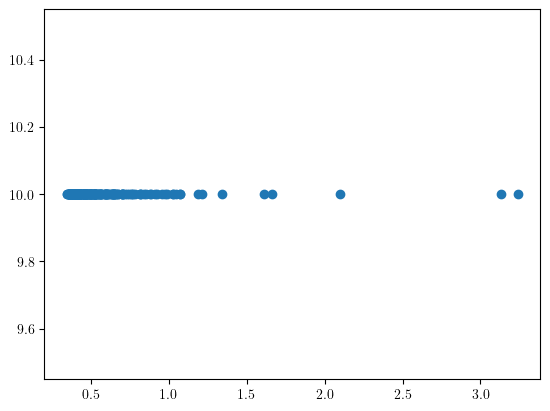

In [404]:
shape = MDF2_params[:, 0]
scale = MDF2_params[:, 1] / 1e+6
plt.scatter(scale, shape)

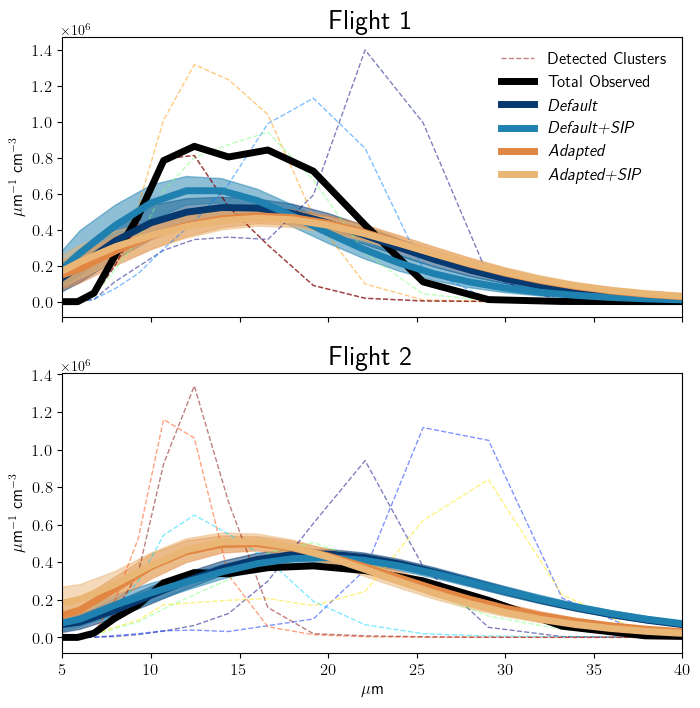

In [431]:
x = np.arange(0, 1e-4, 2e-6)
labels = [r'\textit{Default}', r'\textit{Default+SIP}', r'\textit{Adapted}', r'\textit{Adapted+SIP}']

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

classes_F1 = KSC_F1.get_classed_holos()
classes_F2 = KSC_F2.get_classed_holos()

for i, e in enumerate(classes_F1):
    ax[0].plot(e.diameter * 1e+6, e.Water_PSDnoNorm.mean(dim='time') / e.diameter, 
    color=KSC_F1.class_colors(i), linewidth=1, alpha=0.5, linestyle='dashed')

ax[0].plot(e.diameter * 1e+6, e.Water_PSDnoNorm.mean(dim='time') / e.diameter, 
    color=KSC_F1.class_colors(i), linewidth=1, alpha=0.5, linestyle='dashed', label='Detected Clusters')


#ax[0].plot(classes_F1[0].diameter * 1e+6, total/total_n / classes_F1[0].diameter, color='k', linewidth=5, label='Total Observed')
ax[0].plot(classes_F1[0].diameter * 1e+6, 
KSC_F1.data.Water_PSDnoNorm.mean(dim='time') / KSC_F1.data.diameter, color='k', linewidth=5, label='Total Observed')


upper = []
lower = []
for i in range(len(KSC_F1.data.diameter)):
    e = KSC_F1.data.Water_PSDnoNorm.isel(diameter=i) / KSC_F1.data.diameter[i]
    try:
        t = st.norm.interval(confidence=0.95, loc=e.mean(), scale=st.sem(e))
        lower.append(t[0])
        upper.append(t[1])
    except RuntimeWarning:
        lower.append(np.nan)
        upper.append(np.nan)

#ax[0].fill_between(KSC_F1.data.diameter.to_numpy() * 1e+6, lower, upper, alpha=0.5, color='k')


#ax[0].plot(x * 1e+6, MDF1_ensemble.mean(axis=0), color=get_colors(0), linewidth=5, label='Default')
#ax[0].fill_between(x * 1e+6, MDF1_lower, MDF1_upper, alpha=0.5, color=get_colors(0))

#ax[0].plot(x * 1e+6, MAF1_ensemble.mean(axis=0), color=get_colors(2), linewidth=5, label='Adapted')
#ax[0].fill_between(x * 1e+6, MAF1_lower, MAF1_upper, alpha=0.5, color=get_colors(2))

for i, e in enumerate(SD_F1):
    ax[0].plot(x * 1e+6, e[0].mean(axis=0), color=get_colors(i), linewidth=5, label=labels[i])
    ax[0].fill_between(x * 1e+6, e[1], e[2], alpha=0.5, color=get_colors(i))




for i, e in enumerate(classes_F2):
    ax[1].plot(e.diameter * 1e+6, e.Water_PSDnoNorm.mean(dim='time') / e.diameter, 
    color=KSC_F2.class_colors(i), linewidth=1, alpha=0.5, linestyle='dashed')

ax[1].plot(KSC_F2.data.diameter * 1e+6, 
KSC_F2.data.Water_PSDnoNorm.mean(dim='time') / KSC_F2.data.diameter, color='k', linewidth=5, label='Total Observed')


upper = []
lower = []
for i in range(len(KSC_F2.data.diameter)):
    e = KSC_F2.data.Water_PSDnoNorm.isel(diameter=i) / KSC_F2.data.diameter[i]
    try:
        t = st.norm.interval(confidence=0.95, loc=e.mean(), scale=st.sem(e))
        lower.append(t[0])
        upper.append(t[1])
    except RuntimeWarning:
        lower.append(np.nan)
        upper.append(np.nan)

#ax[1].fill_between(KSC_F2.data.diameter.to_numpy() * 1e+6, lower, np.array(upper), alpha=0.5, color='k')

#ax[1].plot(x * 1e+6, MDF2_ensemble.mean(axis=0), color=get_colors(0), linewidth=5, label='Default')
#ax[1].fill_between(x * 1e+6, MDF2_lower, MDF2_upper, alpha=0.3, color=get_colors(0))

#ax[1].plot(x * 1e+6, MAF2_ensemble.mean(axis=0), color=get_colors(2), linewidth=5, label='Adapted')
#ax[1].fill_between(x * 1e+6, MAF2_lower, MAF2_upper, alpha=0.5, color=get_colors(2))

for i, e in enumerate(SD_F2):
    ax[1].plot(x * 1e+6, e[0].mean(axis=0), color=get_colors(i), linewidth=5, label=labels[i])
    ax[1].fill_between(x * 1e+6, e[1], e[2], alpha=0.5, color=get_colors(i))

#ax[0].set_yscale('log')
#plt.xlabel('Droplet diameter [$\mu$m]')
#plt.ylabel('Size distribution [$\mu$m$^{-1}$ m$^{-3}$]')
#plt.legend()
ax[1].set_xlim(5, 40)
ax[0].legend(fontsize=12, frameon=False)

ax[0].set_ylabel(r'$\mu$m$^{-1}$ cm$^{-3}$', size=12)
ax[1].set_ylabel(r'$\mu$m$^{-1}$ cm$^{-3}$', size=12)
ax[1].set_xlabel(r'$\mu$m', size=12)

ax[0].set_title('Flight 1', size=20)
ax[1].set_title('Flight 2', size=20)
for x in ax:
    x.tick_params(labelsize=12)
plt.subplots_adjust(hspace=0.2)
#plt.ylim(0, 500000)
#fig_name = 'cloud_droplet_size_distr_time'+str(timestep)+'_level'+str(level)+'_20191112'+'.png'
plt.show()